# Double descent in linear regression estimated with gradient descent

The other notebook demonstrated double descent in simple linear regression fitted with analytic methods, but as I will explain, the analytic methods have a discontinuity at the interpolation threshold, an double descent could be blamed on that.

So here I fit linear regression with gradient descent, since that does not know about the interpolation threshold or do anything different at it.  I will show the "double descent" in test error still occurs.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Data set

Here I load a data set to analyze.  In an earlier [R version of this notebook](https://github.com/jeanimal/farewell_bias_variance), I used the "mtcars" data set which has data on various models in Motor Trend cars of the year.

The goal is to predict the miles per gallon (mpg) of various models based on their other characteristics.

In [2]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# Split X and y

Here we put the data in a standard format for sklearn's model estimtion and error metrics.  If you use your own data set, you will need to tweak the target column and remove the non-numeric columns-- or code them into numbers, e.g. with one-hot encoding.

In [5]:
TARGET_COL = "mpg"

In [6]:
NON_NUMERIC_COLS = ["model"]

In [7]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

In [8]:
from double_descent_dar import sample_eval

In [9]:
model = linear_model.LinearRegression(fit_intercept=True)

In [10]:
my_metric = root_mean_squared_error
# my_metric = mean_absolute_error

## Double descent

A paper by Dar et al. (), called "Farewell to Bias Variance?" showed mathematically that double descent could be exhibited by linear regression under certain conditions. 

The paper: 
Yehuda Dar, Muthukumar, V., & Baraniuk, R. (2021). A Farewell to the Bias-Variance Tradeoff? An Overview of the Theory of Overparameterized Machine Learning. https://arxiv.org/abs/2109.02355


Here I show double descent empirically on the mtcars data set (widely used by R users).

Seeing double descent requires that the number of parameters should be a lot MORE than the number of rows. Since the data set has only 9 columns, we achieve this with a trick-- sampling fewer rows.

This section will train on 7 rows (out of a total of 32).

As before, will sample between 2 and 8 columns (out of a total of 9 columns) to see how the error metric varies by the number of parameters.  

The linear regression model will be able to fully interpolate the data at 7 columns because it is fit to 7 rows.

In [11]:
num_train_rows = 7
model = linear_model.LinearRegression(fit_intercept=True)

We will look at the train and test error of root mean squared error.

In [12]:
metric = root_mean_squared_error
metrics = [
        sample_eval.MetricTuple('train', metric_func=metric, dataset_type=sample_eval.DatasetType.train),
        sample_eval.MetricTuple('test', metric_func=metric, dataset_type=sample_eval.DatasetType.test)
    ]

In [13]:
num_samples = 300
num_columns_list = range(1, X.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X, y, num_train_rows, num_columns_list=num_columns_list, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

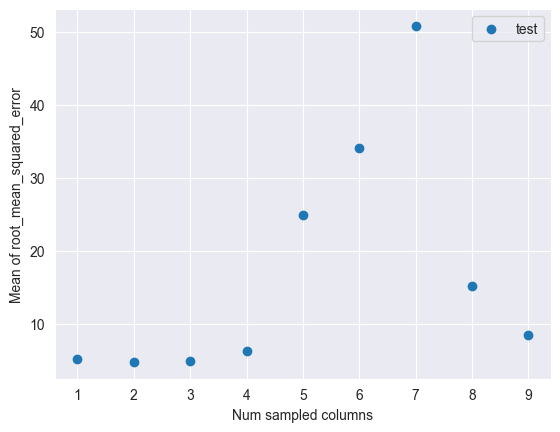

In [14]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

As predicted, there was a spike in test (out of sample) error followed by a descent in error after the spike.  That is double descent in a linear regression.  The maximum was reached at 7 sampled columns.

Double descent was formerly thought to be a weird feature of fitting neural nets, but here we observe it with simple, traditional linear regression.

# Double descent is actually two U curves in linear regression

A recent paper pointed out that different fitting methods are used on different sides of the interpolation threshold in linear regression.  When the number of rows N > number of paramters p, the best estimator involves inverting the N x p matrix.  But a matrix with more columns than rows cannot be inverted, so other parameter estimation methods are required.  The paper argues that it is this change in estimation methods that produces the two humps.  Each estimation method on its own has a U-shaped bias-variance curve, and the so-called double descent shape is just blending these two U's.

The paper:
Curth, A., Jeffares, A., & Schaar, M. van der. (2023, November 2). A U-turn on Double Descent: Rethinking Parameter Counting in Statistical Learning. Thirty-seventh Conference on Neural Information Processing Systems. https://openreview.net/forum?id=O0Lz8XZT2b


# Double descent in linear regression is real

The claim by Curth et al is correct in that many software packages switch their fitting / estimation method depending on whether the number of rows is greater or less than the number of columns.  Note that the original Dar et al paper was mathematical and so would not be subject to this criticism,  However, the sklearn implementation of LinearRegression may have different estimation methods....

So let me demonstrate double descent in a linear regression but using an estimation method that is the same on both sides of the interpolation threshold-- stochastic gradient descent (SGD).  Stochastic gradient descent is also useful to try because it is the same method used to estimate the weights in neural nets.

Notes:
* The SGDRegressor assumes input has been scaled from 0 to 1, so I wrap it inside a pipeline to handle scaling.
* By default the SGDRegressor includes regularization by default (via a penalty), so to make it comparable to the pure LinearRegression example above, I have to set the penalty to None.

In [15]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(), SGDRegressor(random_state=0, penalty=None))

Training on 15 rows, we expect a bias-variance U curve.

In [16]:
num_train_rows = 15

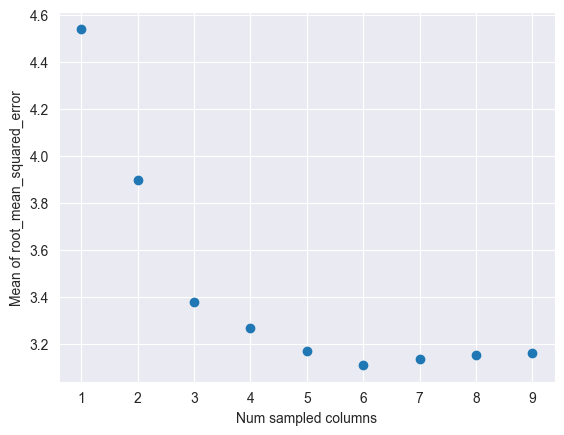

In [17]:
num_samples = 300
random_state = np.random.RandomState(11)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Nice!  This is the "left" half of a U curve.  It minimizes test (out-of-sample) error with 7 columns.

Training on 7 rows, we hope to see double descent. Because it's harder to fit on few rows, we will increase max_iter (as the warnings when I ran with the default max_iter).

In [18]:
model = make_pipeline(StandardScaler(), SGDRegressor(random_state=0, penalty=None, max_iter=2000))

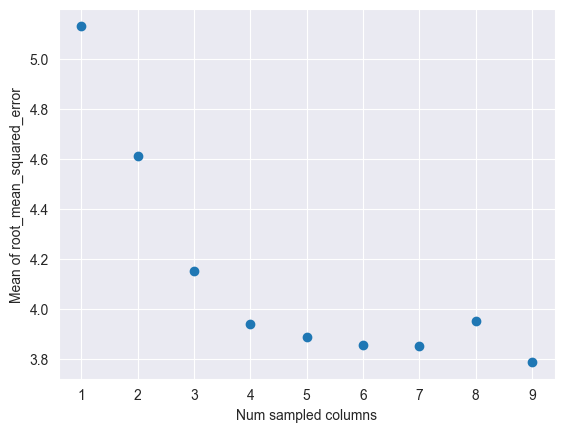

In [19]:
# Lower rows to see if we get double descent.
num_train_rows = 7
num_samples = 300
random_state = np.random.RandomState(12)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Test error bumps up at 8 columns and then goes back down.  Double descent!

## Conclusion

Based on the shapes above, using a consistent estimation method, I argue that **double descent is real** and not merely the overlap of two U curves from two different estimation methods.

# Making sure: Custom stochastic gradient descent linear regression

My friend Dan Goldstein asked how I knew whether sklearn's SGDRegressor didn't use two estimation methods, e.g. defaulting to OLS for speed when num_rows > num_columns.  I looked at the code and there is a lot.

So to be 100% sure there is only one estimation method involved, I coded my own.  A good summary of the intuition and math behind this is in this nice post: https://medium.com/@nikhilparmar9/simple-sgd-implementation-in-python-for-linear-regression-on-boston-housing-data-f63fcaaecfb1

It also served as the initial version of the code, which I wrapped in a class in order to make compatible with sklearn and my wrapper functions for sampling and using sklearn.

In [20]:
from sklearn.exceptions import NotFittedError

class CustomSGDRegression():

    def __init__(self, learning_rate, n_iter, batch_size, divide_by = 1, rng = None, verbose = False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.divide_by = divide_by
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng
        self.verbose = verbose
        self.weights = None
        self.bias = None
    
    def _fit_one_iter(self, X_train, y_train, replace, iter_index):
                    # Randomly sample a small training data set of the batch size.
        row_indices = self.rng.choice(X_train.shape[0], size=self.batch_size, replace=replace)
        x = X_train[row_indices]
        y = y_train[row_indices]
        
        # The iteration has initial gradients of 0.
        w_gradient=np.zeros(shape=(1, X_train.shape[1]))
        b_gradient=0
        
        if self.verbose:
            print(f'iteration #: {iter_index}, weights: {self.weights}, bias: {self.bias}')
        for i in range(self.batch_size): # Use the derivative to update the gradient.
            prediction = np.dot(self.weights, x[i]) + self.bias
            w_gradient = w_gradient+(-2)*x[i]*(y[i]-(prediction))
            b_gradient = b_gradient+(-2)*(y[i]-(prediction))
        
        # Update the weights and bias with the above calculated gradients.
        self.weights = self.weights - self.learning_rate*(w_gradient/self.batch_size)
        self.bias = self.bias - self.learning_rate*(b_gradient/self.batch_size)
        
        # Divide the learning rate by the specified value.
        self.learning_rate=self.learning_rate/self.divide_by
            

    def fit(self, X_train, y_train, replace=True):
        # Ensure X_train and y_train are numpy arrays.
        if isinstance(X_train, pd.DataFrame): 
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.to_numpy()
        # Initialize the weights and bias (a.k.a. the intercept). 
        self.weights = np.zeros(shape=(1, X_train.shape[1]))
        self.bias = 0
        [self._fit_one_iter(X_train, y_train, replace, iter_index) for iter_index in range(self.n_iter)]
        return self.weights, self.bias
    
    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise NotFittedError('You must fit before predict')
        if isinstance(X, pd.DataFrame): 
            X = X.to_numpy()
        y_pred=[]
        for i in range(len(X)):
            y=np.dot(X[i], np.squeeze(self.weights)) + np.squeeze(self.bias)
            y_pred.append(y)
        return np.array(y_pred)

Note that I did tune the parameters in the constructor below to get reasonable-looking error.  sklearn uses best-in class defaults.  Also, my model is slow-- sklearn has many speed-ups, including early stopping.  Use sklearn.

In [21]:
rng = np.random.RandomState(42)
model = make_pipeline(StandardScaler(), CustomSGDRegression(learning_rate=0.001, n_iter=1000, batch_size=9, rng=rng))

Training on 15 rows, we expect a bias-variance U curve.

In [22]:
y_df = pd.DataFrame(y)

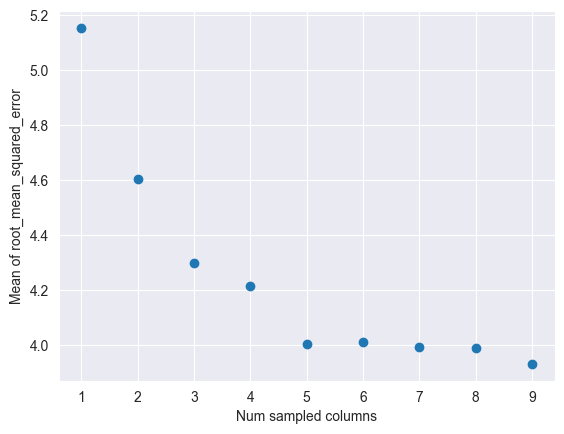

In [23]:
num_train_rows = 15
num_samples = 300
random_state = np.random.RandomState(11)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y_df, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Notice the scale on the Y axis-- 4.0 to 5.2.  The keras SGD regression Y axis ranged from 3.8 to 5.0, so they have a better-tuned (and faster-running) SGD regression.

Also, the shape is at best only the left half of a U.

Training on 7 rows, we hope to see double descent.  We need to lower the batch size because 9 is more than the number of rows!  I also increased the number of iterations because this data is harder to fit. (Warning: it's slow to run.  My implementation of stochastic gradient descent is FAR slower than keras' implementation.)

In [24]:
model = make_pipeline(StandardScaler(), CustomSGDRegression(learning_rate=0.001, n_iter=2000, batch_size=6, rng=rng))

In [25]:
y_df = pd.DataFrame(y)

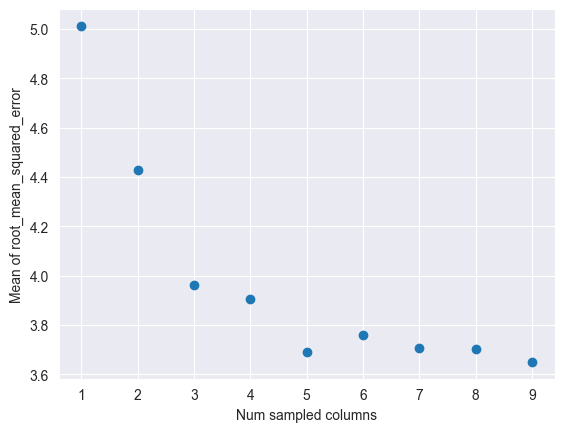

In [26]:
num_train_rows = 7
num_samples = 300
random_state = np.random.RandomState(11)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y_df, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

This plot is consistent with double descent, with a bump up at 6 columns.  That saide, it is noisy. I might need to increase the number of samples or the number of iterations to get a less-noisy plot.

# Appendix: Fun with an MLPRegressor

One cool thing about building all this with sklearn is that there are a bunch of other estimation models we can try.  It is a great system to experiment with and build intuition!  Below are a couple models (commented out but to give you ideas).

In [27]:
# model = RandomForestRegressor()
# model = linear_model.Ridge(alpha=.5)

For this appendix, I chose to look at a simple one-layer, feed-forward neural net (MLP = multi-layer perceptron) that is fit with stochastic gradient descent.  sklearn calls it MLPRegressor.

Unlike the previous models studied here, it is not linear-- the activation function makes it non-linear.

In [28]:
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# TODO: scale hidden layer neurons to number of columns.
model = make_pipeline(
    StandardScaler(), 
    MLPRegressor(hidden_layer_sizes=(4,), validation_fraction=0, solver="sgd", random_state=0))

In [29]:
# First just look for the bias-variance U curve
num_train_rows = 15

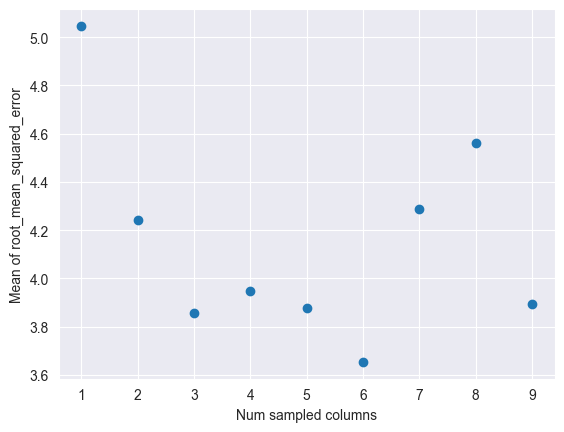

In [30]:
num_samples = 400
random_state = np.random.RandomState(44)  # set for reproducibility
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
num_columns_list = range(1, X.shape[1])
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
        X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
        metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

This looks sort of U-shaped.  There were a lot of warnings I ignored and should look into.

In [31]:
# Lower the number of rows to look for double descent.
num_train_rows = 5

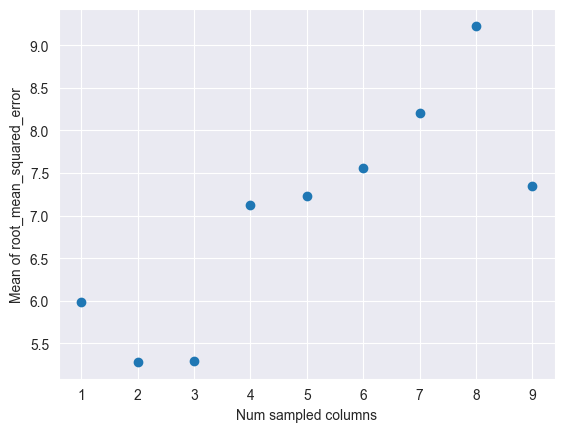

In [32]:
num_samples = 500
random_state = np.random.RandomState(55)  # set for reproducibility
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
num_columns_list = range(1, X.shape[1])
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
        X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
        metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

I'm not sure what pattern I'm seeing.  But to do this in an apples-to-apples way with the prior regression studies, the number of hidden layer neurons should correspond to the number of sampled columns (because a weight is estimated for each neuron, and we want the number of parameters to scale, not just number of inputs).  Or maybe something else?  I'm still working on this one.